In [115]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import pointbiserialr
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree, naive_bayes, ensemble
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from copy import deepcopy
from pprint import pprint
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Python/TFG')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
def comparePredict(prediction, testdata, should_print = True):
  """
  Compares the predicted system output data to the 'gold standard' data.
  Returns a dictionary with the recall, precision, and accuracy inside.
  Dtypes should match
  """
  tp = 1
  tn = 1
  fp = 1
  fn = 1

  for i in range(len(prediction)):
    if prediction[i] == testdata[i]:
      if prediction[i] == 1.0:
        tp+=1
      else:
        tn+=1
    else:
      if prediction[i] == 1.0:
        fp+=1
      else:
        fn+=1
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  acc = (tp+tn)/(tp+tn+fp+fn)
  f1 = (2*precision*recall)/(precision+recall)
  if should_print:
    print(f"""
          True positives = {tp-1}
          True negatives = {tn-1}
          False positives = {fp-1}
          False negatives = {fn-1}
          Precision = {precision}
          Recall = {recall}
          Accuracy = {(acc)*100}%
          F1 = {(f1)*100}%
    """)
  return {"precision" : precision, "recall" : recall, "accuracy" : acc, "f1" : f1}

def plotCorrelation(serie, n):
  fig, ax = plt.subplots()
  ax.bar(serie.index[:n], height=abs(serie).to_list()[:n], color = '#CB0236')
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.spines["left"].set_visible(False)
  plt.xticks(serie.index[:n], rotation=75)
  plt.show()

# Process dataset

In [ ]:
!pip install stanza
!pip install textstat
!pip install language-tool-python
stanza.download("es")
from ClassesAndFunctions import *
df = Dataset(pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Python/TFG/out.xlsx")) # This computes the features and saves them into a DataFrame
df.to_excel("/content/drive/MyDrive/Colab Notebooks/Python/TFG/test.xlsx", engine="openpyxl") # Saves the dataframe into an excel file. Check the path, as it's written to work with my drive in google colab

# Or load data from an excel file

In [153]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Python/TFG/test.xlsx', header=0, index_col=0) # Read an excel from the path. The path written to work with my drive in google colab

df = df.sample(frac=1).reset_index(drop=True) # Shuffles the dataframe

# DataFrames containing the stratified data (label 1 for AI generated and label 0 got human generated texts)
df_gpt = df[df["label"] == 1]
df_human = df[df["label"] == 0]

len(df_gpt), len(df_human)

(425, 2890)

# Correlation

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:5657: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


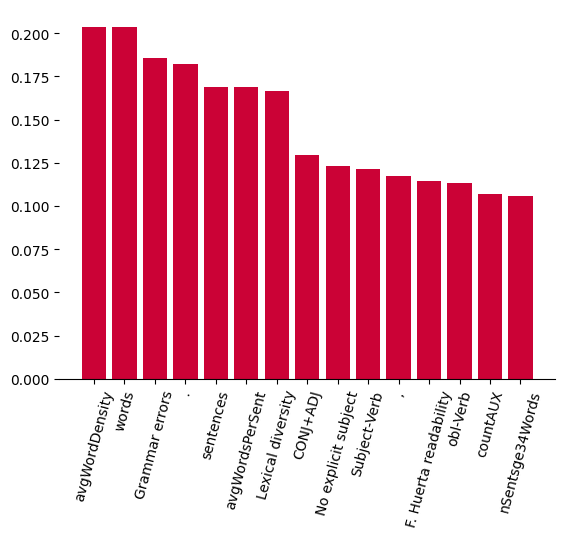

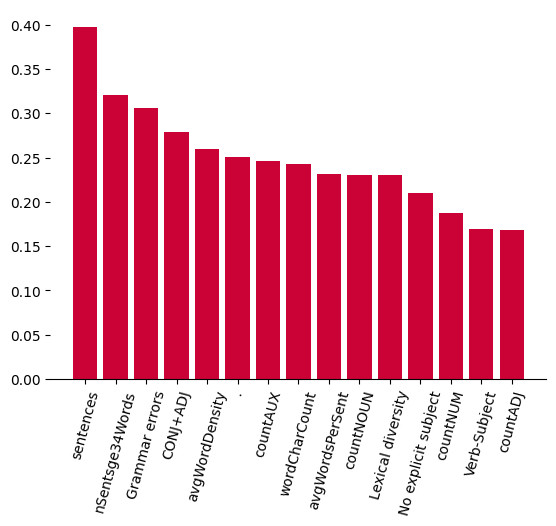

In [154]:
# This dataframe contains the name of each feature as row index and the correlation coefficients (includes p-value of point-biserial) as columns
correlations = pd.DataFrame(columns=["point biserial correlation","p-value", "mutual info"])

for col in df.columns: # Fills the dataframe with the correlation data
    if col not in ("text", "label"):
        correlations.loc[col] = list(pointbiserialr(df["label"], df[col]))+[mutual_info_classif(df[col].to_numpy().reshape((-1, 1)), df["label"])[0]]

# Plots the n most correlated features in a bar graph
n = 15
plotCorrelation(correlations.sort_values(by="mutual info" ,key=lambda v: abs(v), ascending=False)["mutual info"], n)
plotCorrelation(correlations.sort_values(by="point biserial correlation" ,key=lambda v: abs(v), ascending=False)["point biserial correlation"], n)

# Model

Each model in the 'models' list is tested and for each of these each iteration in the nested loop the features used by the model are reduced by one (from the one with the lowest correlation to the one with the highest). Then the iteration of the loop, the list of the features used, the evaluation metrics of the model and a deep copy of the model object are saved as a tuple into a dictionary, which has the models tested as keys and the list of tuples as values. Thus the optimal set of features can be retrieved from the tuple with the highest F1 score.

In [155]:
# The order in which the features will be removed in order to minimize noise
order_by_coefficient = "point biserial correlation"
#order_by_coefficient = "mutual info"
feature_cols = correlations.sort_values(by=order_by_coefficient ,key=lambda v: abs(v), ascending=False)[order_by_coefficient].index

In [156]:
maxiters = 100000 #Max iterations for the logistic regression and Support Vector Classification models

# List with the models that will be tested
models = (svm.SVC(max_iter=maxiters), LogisticRegression(max_iter=maxiters), tree.DecisionTreeClassifier(), ensemble.RandomForestClassifier(), ensemble.AdaBoostClassifier(), naive_bayes.GaussianNB())

# This Dictionary will contain the model name as keys and a list of tuples as values.
# Each tuple contains the number of features that have been removed in index 0, the list of features used in index 1, the evaluation metrics in index 2
# and a deep copy of the model in index 3, which will be used later
models_eval = dict()

for model in models:
  for i in range(len(feature_cols)-1):
    # Generate train and test data. The data is sampled in a stratified way, taking the same proportion of each label.
    x_train = np.array(df_gpt[feature_cols[:len(feature_cols)-1-i]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-1-i]][:int(0.7*len(df_human))].to_numpy().tolist())
    y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
    x_test  = np.array(df_gpt[feature_cols[:len(feature_cols)-1-i]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-1-i]][int(0.7*len(df_human)):].to_numpy().tolist())
    y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
    model.fit(x_train, y_train) # Model training
    y_prediction = model.predict(x_test) # Model prediction for evaluation
    if type(model).__name__ in models_eval.keys(): # Add the features used, evaluation metrics, and deep copy of the model to the dict
      models_eval[type(model).__name__].append((i, list(feature_cols[:len(feature_cols)-1-i]), comparePredict(y_prediction, y_test, False), deepcopy(model)))
    else: # Create the key if the name of the model hasn't been found
      models_eval[type(model).__name__] = [(i, list(feature_cols[:len(feature_cols)-1-i]), comparePredict(y_prediction, y_test, False), deepcopy(model))]

In [157]:
best_model = () # Best model used (the deep copy of the model), should point to the index 3 of the tuple
best_f1 = 0 # Here the tuple of the best performing model will be stored
for k in models_eval.keys():
  highest = max(models_eval[k], key=lambda x: x[2]["f1"])
  print(k, ":", max(models_eval[k], key=lambda x: x[2]["f1"])[2]["f1"])
  if isinstance(best_f1, int) or highest[2]["f1"] > best_f1[2]["f1"]:
    best_f1=highest
    best_model = best_f1[3]

SVC : 0.8847583643122677
LogisticRegression : 0.8774703557312253
DecisionTreeClassifier : 0.9416342412451363
RandomForestClassifier : 0.96875
AdaBoostClassifier : 0.9652509652509652
GaussianNB : 0.9236363636363637


In [158]:
print(f"The model that performed best was {type(best_model).__name__} with an F1 score of {best_f1[2]['f1']} using the following features: \n{best_f1[1]}\nFor a total of {len(best_f1[1])} features.")
print("Its evaluation metrics are:")
for k, v in best_f1[2].items():
  print(f"\t{k}: {v}")

The model that performed best was RandomForestClassifier with an F1 score of 0.96875 using the following features: 
['sentences', 'nSentsge34Words', 'Grammar errors', 'CONJ+ADJ', 'avgWordDensity', '.', 'countAUX', 'wordCharCount', 'avgWordsPerSent', 'countNOUN', 'Lexical diversity', 'No explicit subject', 'countNUM', 'Verb-Subject', 'countADJ', 'Object-Verb', 'countPROPN', 'words', 'Crawford score', 'Verb-Object', 'TTR', '!', '(', ')', 'obl-Verb', 'countSCONJ', 'PRON+VERB', ',', 'Lexical density', 'CONJ+ADV', 'CONJ+NOUN', 'Subject-Verb', 'CONJ+VERB', ':', 'countCCONJ', 'NERS', 'F. Huerta readability', 'countPRON', 'ADJ+VERB', 'countADP', '"', 'Superlatives', 'G. Polini', ';', 'countVERB', '?', 'NOUN+VERB', 'countADV']
For a total of 48 features.
Its evaluation metrics are:
	precision: 0.9841269841269841
	recall: 0.9538461538461539
	accuracy: 0.992
	f1: 0.96875


In [159]:
print("Full dataset prediction: ")
comparePredict(best_model.predict(df[best_f1[1]].to_numpy()), df["label"].to_numpy())

Full dataset prediction: 

          True positives = 420
          True negatives = 2889
          False positives = 1
          False negatives = 5
          Precision = 0.9952718676122931
          Recall = 0.9859484777517564
          Accuracy = 99.75896354323591%
          F1 = 99.05882352941177%
    


{'precision': 0.9952718676122931,
 'recall': 0.9859484777517564,
 'accuracy': 0.9975896354323591,
 'f1': 0.9905882352941177}

# Save Model

In [161]:
import pickle
# Save the model into a pickle file
with open('model.pkl','wb') as f:
    pickle.dump(best_model,f)